In [1]:
#spatial visualization
import torch
import torch.nn as nn
import hexagdly
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from keras.utils.np_utils import to_categorical

In [359]:
#this is to do convolution.
class F_Network_all(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(F_Network_all,self).__init__()
        ## global state
        self.global_fc = nn.Sequential((nn.Linear(64*6*6, 256)))  # ,nn.Dropout(0.5)
        ## local state
        self.output_f = nn.Linear(128,1+20) #two dims
        ## concat_fc
        ## concat_fc
        self.cat_fc = nn.Linear(64 * 6 * 6 + 1347 + 1, 256)
        self.dense1 = nn.Linear(54 * 46 * 3, 512)
        self.new_cat_fc = nn.Linear(512 + 1347 + 1, 128)


        self.local1=nn.Linear(1347+1,512)
        self.local2=nn.Linear(512,128)
        self.local_out=nn.Linear(128,1+8) #out dimension

    def forward(self,local_state):
        state=F.relu(self.local1(local_state[:,1:]))
        state=F.relu(self.local2(state))
        f_value=self.output_f(state)

        return f_value

In [360]:
def construct_f_features_batch(state):
        #use one-hot encoding
        state=np.array(state)
        loc=state[:,[1]]; t=state[:,[0]]//600%144 ; soc=state[:,[2]]
        loc = to_categorical(loc, num_classes=1347)
        # t = to_categorical(t, num_classes=144)
        t = (state[:, [0]]//60 %1440)/1440
        # time_feature = 2 * np.pi * t/ (24 * 60 * 60)
        # time_feature=time_feature.astype(np.float32)
        # t1=np.sin(time_feature)
        # t2=np.cos(time_feature)

        state_features=np.concatenate((soc,loc,t),axis=1)
        state_features=state_features.astype(np.float32)

        return state_features #dimension is NUM_REACHABLE_HEX+1+144 
    
def load_parameter(model_file):
        checkpoint = torch.load(model_file)
        params=model_file.split('_')
        params[-1]=params[-1][:-4]
        trial=int(params[-1])
        train_step=int(params[-2])
        device=torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
        f_network_list=[]
        for _ in range(len(checkpoint['net_f'])):
            f_network = F_Network_all(0, 1 + 6)
            f_network_list.append(f_network.to(device))
        [f.load_state_dict(i) for f,i in zip(f_network_list,checkpoint['net_f'])] #load h
        return f_network_list


In [677]:
#load f_net
mode_file='logs/test/cnn_dqn_model/dqn_fh_0.005_3_20160_19600.pkl'
f_nets=load_parameter(mode_file)

In [678]:
df = gpd.read_file('../data/NYC_shapefiles/labeled_clustered_hex.shp')  # tagged_cluster_hex
print(df.head())

for tick in range(1440):
    t=tick*60
    state=[]
    for i in range(1347):
        state.append([t,i,0])
    device=torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
    p_state=torch.from_numpy(construct_f_features_batch(state)).to(device)

    f=f_nets[0].forward(p_state).detach()
    vals=f[:,1:].pow(2).sum(-1).pow(0.5).cpu().numpy()
#     print(max(vals),min(vals))


#     df['values']=vals
#     df.plot('values',cmap='Reds',vmin=0,vmax=3)



   Id GRID_ID      lat      lon  id_1  cluster_la  tagged_lat  tagged_lon  \
0   0   AU-55  40.5623 -73.9113     3           0   40.562281  -73.911379   
1   0   AZ-55  40.5656 -73.8738     1           2   40.565813  -73.873166   
2   0   AJ-54  40.5722 -73.9937    68           0   40.572204  -73.993668   
3   0   AL-54  40.5722 -73.9787   135           0   40.573567  -73.978102   
4   0   AH-53  40.5788 -74.0087     7           0   40.578863  -74.008854   

   col_id  row_id   snap_lat   snap_lon  CELL_ID  labels  \
0      17      53  40.562281 -73.911379        0       0   
1      22      53  40.565813 -73.873166        1      17   
2       6      52  40.572204 -73.993668        2      34   
3       8      52  40.573567 -73.978102        3      34   
4       4      51  40.578863 -74.008854        4      34   

                                            geometry  
0  POLYGON ((-73.90630 40.56230, -73.90881 40.559...  
1  POLYGON ((-73.86885 40.56556, -73.87136 40.562...  
2  POLYGON 

In [679]:

t=900*60
state=[]
for i in range(1347):
    state.append([t,i,0])
    device=torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
    p_state=torch.from_numpy(construct_f_features_batch(state)).to(device)
    
f1=f_nets[0].forward(p_state).detach().cpu().numpy()
f2=f_nets[1].forward(p_state).detach().cpu().numpy()
f3=f_nets[2].forward(p_state).detach().cpu().numpy()



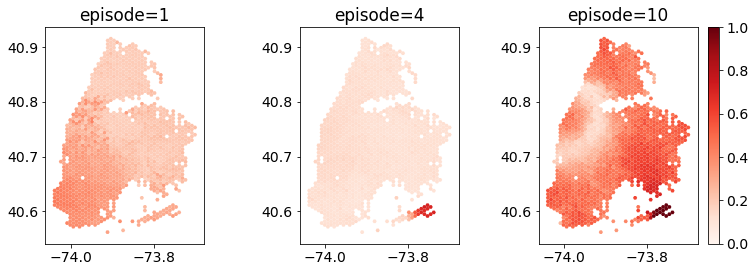

In [680]:
hex_id=234
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
dist=[]
fv=[f1,f2,f3]
fig,ax=plt.subplots(1,3,figsize=(11,4))
epi=[1,4,10]
for i in range(3):
    dist=[]
    for hx in range(1347):
        f=fv[i]
        dist_ = np.linalg.norm(f[hx,2:])
        dist.append(dist_-0.5)
    df['values']=dist
    if i==2:
        l=True
    else:
        l=False
    df.plot('values',cmap='Reds',vmin=0,vmax=1,ax=ax[i],legend=l)
    ax[i].set_title('episode={}'.format(epi[i]))
plt.tight_layout()
plt.savefig('learned_drqn_emb_drdqn.pdf')
    

<AxesSubplot:>

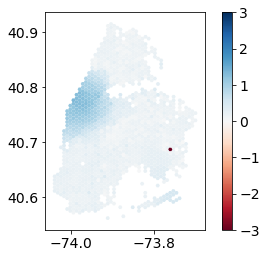

In [550]:
hex_id=500
dist=[]
for hx in range(1347):
    dist_ = np.linalg.norm(f[hex_id,2:]-f[hx,2:])
    dist.append(dist_)
df['values']=dist
df.loc[hex_id,'values']=-10
df.plot('values',cmap='RdBu',vmin=-3,vmax=3,legend=True)

## plot actions based on local clusters
label id of interest:  3, 4,5 (next to LGA) ,8 ,10, 13 (next to JFK), 19, 20

In [644]:
def viz_cluster(df,cid):
    df['values']=0
    df.loc[df['labels']==cid,'values']=1
    df.plot('values',cmap='RdBu',vmin=-3,vmax=3,legend=True)
    
def read_info(seed,option):
    file='logs/test_results/matching_od_{}_0.005_nc_{}.csv'.format(option,seed)
    file2='logs/test_results/cruising_od_{}_0.005_nc_{}.csv'.format(option,seed)
    od_gap='logs/test_results/demand_supply_gap_{}_0.005_nc_{}.csv'.format(option,seed)
    parsed_results='logs/test_results/parsed_results_{}_0.005_nc_{}.csv'.format(option,seed)
    match_cols=['vid','tick','from','to','dist','trip_time','action']
    relo_cols=['vid','tick','from','to','dist','trip_time','action']
    trip_df=pd.read_csv(file,names=match_cols, header=None,skiprows=1)
    relo_df=pd.read_csv(file2,names=match_cols, header=None,skiprows=1)
    gap_df=pd.read_csv(od_gap)
    parsed_results=pd.read_csv(parsed_results)
    return trip_df,relo_df,gap_df,parsed_results


def read_train_info(seed,option):
    file='logs/matching_od_{}_0.005_nc_{}.csv'.format(option,seed)
    file2='logs/cruising_od_{}_0.005_nc_{}.csv'.format(option,seed)
    od_gap='logs/demand_supply_gap_{}_0.005_nc_{}.csv'.format(option,seed)
    parsed_results='logs/parsed_results_{}_0.005_nc_{}.csv'.format(option,seed)
    match_cols=['vid','tick','from','to','dist','trip_time','action']
    relo_cols=['vid','tick','from','to','dist','trip_time','action']
    trip_df=pd.read_csv(file,names=match_cols, header=None,skiprows=1)
    relo_df=pd.read_csv(file2,names=match_cols, header=None,skiprows=1)
    gap_df=pd.read_csv(od_gap)
    parsed_results=pd.read_csv(parsed_results)
    return trip_df,relo_df,gap_df,parsed_results

def track_trajectory(df,h_id,opt=False):
    end=1
    trajec=[]
    steps=[]
    if  sum(df['from'].isin(h_id))==0: #not even relocate from here
        return trajec,steps
    t_trajec=[]
    steps=[]
    for _,row in df.iterrows():
        _,tick,from_,to_,_,_,action=row
        if end==1 and from_ in h_id: #first encounter
            if opt==True:
                if action<=6:
                    continue
            end=0
            step=1
#             t_trajec.append(from_)
            t_trajec.append(to_)
            last_to=to_
        elif end==0 and from_==last_to:#continued relocation from last location
            if opt==True:
                if action<=6:
                    continue
                
            t_trajec.append(to_)
            last_to=to_
            step+=1
        elif end==0 and from_!=last_to:
            end=1
            trajec+=t_trajec
            t_trajec=[]
            steps.append(step)
            step=0
#             if end==0:
#                 trajec.append(-1)
#                 act.append(-1)
    return trajec,steps


In [216]:
t_dqn,r_dqn,g_dqn,_=read_train_info(11100,0)
t_drdqn,r_drdqn,g_drdqn,_=read_train_info(1964,3)

   vid  tick  from   to  dist  trip_time  action
0  278   240   118  118     0          0       0
1   26   240   122  122     0          0       0
2  453   240   207  207     0          0       0
3  451   240   262  262     0          0       0
4  125   240   418  418     0          0       0


<ipython-input-202-e4daec8eb437>:14: RuntimeWarning: invalid value encountered in true_divide
  o_percent=option_count/(option_count+action_count)


[0. 0. 0. ... 0. 0. 0.]
560


<AxesSubplot:>

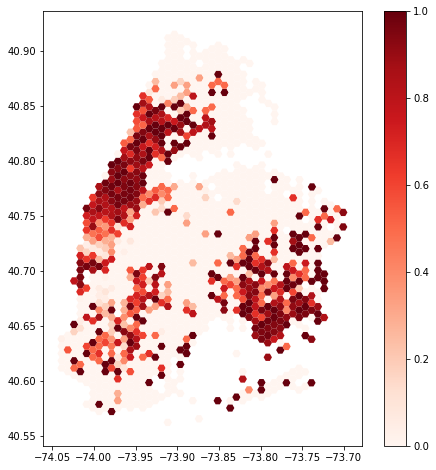

In [202]:
#see option percentage in each zone
print(r_drdqn.head())
action_count=np.zeros(1347)
option_count=np.zeros(1347)

tdf=r_drdqn[(r_drdqn['tick']//60%1440>600) & (r_drdqn['tick']//60%1440<1000)]
# tdf=r_drdqn
for hid in range(1347):
    a=tdf[(tdf['from']==hid)&(tdf.action>6)]
    o=tdf[(tdf['from']==hid)&(tdf.action<=6)]
    action_count[hid]=a.shape[0]
    option_count[hid]=o.shape[0]

o_percent=option_count/(option_count+action_count)
o_percent[np.isnan(o_percent)]=0
print(o_percent)


fig,ax=plt.subplots(figsize=(8,8))
df['option']=o_percent
print(sum(o_percent>0))
df.plot('option',cmap='Reds',legend=True,ax=ax,vmin=0,vmax=1)

In [642]:
#by drivers
def track_reach(df,h_ids,opt=False):
    #track the reached area from the given cluster
    t_df=df.groupby('vid')
    hexs=[]
    steps=[]
    for v in t_df.groups:
        tdf=t_df.get_group(v)
        trajecs,step=track_trajectory(tdf,h_ids,opt=False)
        hexs+=trajecs
        steps+=step
        
    return np.array(hexs),steps
    

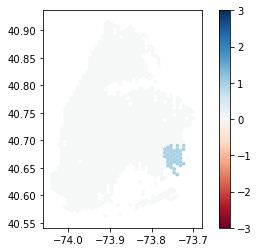

In [447]:
cid=36
viz_cluster(df,cid)

dqn steps: 1.4461538461538461 drdqn steps: 1.0


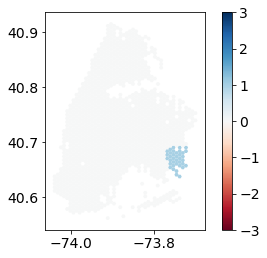

In [651]:
#starting from some location 

t_dqn,r_dqn,g_dqn,_=read_train_info(11201,0)
t_drdqn,r_drdqn,g_drdqn,_=read_train_info(19601,3)

e1=5
e2=9


tdqn=r_dqn[(r_dqn['tick']<1440*e2*60) & (r_dqn['tick']>1440*e1*60)]
tdrdqn=r_drdqn[(r_drdqn['tick']<1440*e2*60) & (r_drdqn['tick']>1440*e1*60)]

# tdqn=tdqn[(tdqn['tick']//60%1440>900) & (tdqn['tick']//60%1440<1020)]
# tdrdqn=tdrdqn[(tdrdqn['tick']//60%1440>900) & (tdrdqn['tick']//60%1440<1020)]


cid=36
viz_cluster(df,cid)
h_ids=df[df['labels']==cid].index
# h_ids=h_ids[4:5]

h_ids=[234]  #LGA:956, 959, 989, 990, 991 JFK: 237, 238, 267, 268, 269  #otheruseful: 100 and 234


#also report how many steps before a trip is matched 

reached_dqn,steps_dqn=track_reach(tdqn,h_ids)
reached_drdqn,steps_drdqn=track_reach(tdrdqn,h_ids,opt=True)

print('dqn steps:',np.mean(steps_dqn),'drdqn steps:',np.mean(steps_drdqn))


visit_counts=np.zeros(1347)
for i in range(1347):
    visit_counts[i]+=sum(reached_dqn==i)

visit_dqn=visit_counts/sum(visit_counts)

visit_counts=np.zeros(1347)
for i in range(1347):
    visit_counts[i]+=sum(reached_drdqn==i)

visit_drdqn=visit_counts/sum(visit_counts)


10532
17145
[0.09756098 0.02439024 0.02439024 0.09756098 0.09756098 0.02439024
 0.14634146 0.24390244 0.09756098 0.02439024 0.12195122]


<ipython-input-638-b3ac99690b23>:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loc=subdf.centroid


234


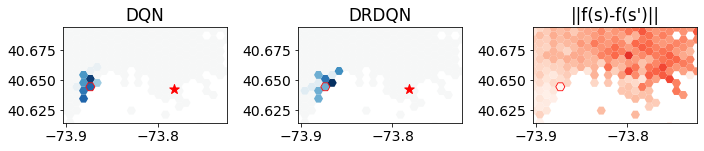

In [638]:
v=0.2
print(sum(reached_drdqn))
print(sum(reached_dqn))
fig,ax=plt.subplots(1,3,figsize=(10,6))
df['attr']=visit_dqn
df.plot('attr',cmap='RdBu',ax=ax[0],vmin=-v,vmax=v)
subdf=df[df.index.isin(h_ids)]
subdf.plot(facecolor="none", edgecolor='red', lw=.8,ax=ax[0])
ax[0].set_title('DQN')
ax[0].scatter(-73.7817815,40.6429189,s=100,color='red',marker='*')

df['attr']=visit_drdqn
print(visit_drdqn[visit_drdqn>0])
df.plot('attr',cmap='RdBu',ax=ax[1],vmin=-v,vmax=v)
subdf=df[df.index.isin(h_ids)]
subdf.plot(facecolor="none", edgecolor='red', lw=.8,ax=ax[1])
ax[1].set_title('DRDQN')
ax[1].scatter(-73.7817815,40.6429189,s=100,color='red',marker='*')

loc=subdf.centroid
x=loc.geometry.x.to_list()[0]
y=loc.geometry.y.to_list()[0]
for ax_ in ax:
    ax_.set_xlim([x-0.03,x+0.15])
    ax_.set_ylim([y-0.03,y+0.05])
    
    
t=500*60
state=[]
for i in range(1347):
    state.append([t,i,0])
    device=torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
    p_state=torch.from_numpy(construct_f_features_batch(state)).to(device)
    
f1=f_nets[0].forward(p_state).detach().cpu().numpy()
f2=f_nets[1].forward(p_state).detach().cpu().numpy()
f3=f_nets[2].forward(p_state).detach().cpu().numpy()



hex_id=h_ids[0]
print(hex_id)
dist=[]
fv=[f1,f2,f3]
for i in range(1):
    dist1=[]
    dist2=[]
    for hx in range(1347):
        f=fv[i]
        dist_ = np.linalg.norm(f[hx,1:])-0.5
        dist__ = np.linalg.norm(f[hx,1:]-f[hex_id,1:])
        dist1.append(dist_)
        dist2.append(dist__)
    df['values']=dist1
    df['values2']=dist2
    df.plot('values2',cmap='Reds',vmin=0,vmax=1,ax=ax[2])
    subdf.plot(facecolor="none", edgecolor='red', lw=.8,ax=ax[2])
    ax[2].set_title("||f(s)-f(s')||")
plt.tight_layout()
plt.savefig('example_epi1.pdf')